# Generating features

In [ ]:
import ast
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import datetime
from functools import partial
from sklearn.inspection import permutation_importance
import numpy as np
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

In [2]:
data_path = "./data/"

In [3]:
X_public = pd.read_csv(data_path + "train.csv", sep=";")
X_test = pd.read_csv(data_path + "test.csv", sep=";")
y_public = pd.read_csv(data_path + "train_labels.csv", sep=";", index_col="user_id")

In [4]:
def get_domain(row):
    # 8 - длина https://
    # потом берем domain
    return row["referer"][8:].split("/")[0]


def get_path(row):
    # 8 - длина https://
    # path - всегда или 0 хешей или 1
    splitted = row["referer"][8:].split("/")
    if len(splitted) == 1 or splitted[1] == "":
        return "none"
    return splitted[1]


X_public["domain"] = X_public.apply(get_domain, axis=1)
X_public["path"] = X_public.apply(get_path, axis=1)
X_test["domain"] = X_test.apply(get_domain, axis=1)
X_test["path"] = X_test.apply(get_path, axis=1)

referer_vectors = pd.read_csv(data_path + "referer_vectors.csv", sep=";")
geo_info = pd.read_csv(data_path + "geo_info.csv", sep=";")

X_public = pd.merge(X_public, referer_vectors, on="referer", how="left")
X_test = pd.merge(X_test, referer_vectors, on="referer", how="left")

X_public = pd.merge(X_public, geo_info, on="geo_id", how="left")
X_test = pd.merge(X_test, geo_info, on="geo_id", how="left")

In [5]:
def get_time_features(df):
    df["request_datetime"] = pd.to_datetime(df["request_ts"])
    df["hour"] = df["request_datetime"].dt.hour

    df["is_work_hours"] = ((df["hour"] >= 9) & (df["hour"] < 18)).astype(int)
    df["is_lunch_time"] = ((df["hour"] >= 12) & (df["hour"] < 14)).astype(int)

    return df


X_public = get_time_features(X_public)
X_test = get_time_features(X_test)

In [6]:
X_public["user_agent"] = X_public["user_agent"].fillna("{}")
X_test["user_agent"] = X_test["user_agent"].fillna("{}")


def extract_user_agent_features(df):
    user_agent_dicts = df["user_agent"].apply(ast.literal_eval)

    df["browser"] = user_agent_dicts.apply(lambda x: x.get("browser", "unknown"))
    df["browser_version"] = user_agent_dicts.apply(
        lambda x: x.get("browser_version", "unknown").split(".")[0]
    )
    df["browser+version"] = df["browser"] + df["browser_version"]
    df["os"] = user_agent_dicts.apply(lambda x: x.get("os", "unknown"))
    df["browser+os"] = df["browser"] + df["os"]
    df["os_version"] = user_agent_dicts.apply(lambda x: x.get("os_version", "unknown"))
    df["os+os_version"] = df["os"] + df["os_version"]

    df["browser+domain"] = df["browser"] + df["domain"]
    df["browser+os+domain"] = df["browser"] + df["os"] + df["domain"]
    df["country_id+domain"] = df["country_id"] + df["domain"]

    return df


X_public = extract_user_agent_features(X_public)
X_test = extract_user_agent_features(X_test)

In [7]:
def domain_referer_frequency(df, domain_col='domain', referer_col='referer'):
    domain_freq = df[domain_col].value_counts().reset_index()
    domain_freq.columns = [domain_col, 'domain_frequency']
    referer_freq = df[referer_col].value_counts().reset_index()
    referer_freq.columns = [referer_col, 'referer_frequency']
    df = df.merge(domain_freq, on=domain_col, how='left').merge(referer_freq, on=referer_col, how='left')
    return df

X_public = domain_referer_frequency(X_public)
X_test = domain_referer_frequency(X_test)

In [8]:
def path_frequency(df, path_col='path'):
    path_freq = df[path_col].value_counts().reset_index()
    path_freq.columns = [path_col, 'path_frequency']
    df = df.merge(path_freq, on=path_col, how='left')
    return df

X_public = path_frequency(X_public)
X_test = path_frequency(X_test)

In [9]:
X_public["count_user_id"] = X_public.groupby("user_id")["user_id"].transform("count")
X_test["count_user_id"] = X_test.groupby("user_id")["user_id"].transform("count")

for col in referer_vectors.columns[:-1]:
    X_public[f"mean_{col}_by_user_id"] = X_public.groupby("user_id")[col].transform(
        "mean"
    )
    X_test[f"mean_{col}_by_user_id"] = X_test.groupby("user_id")[col].transform("mean")

X_public["unique_domains_by_user_id"] = X_public.groupby("user_id")["domain"].transform(
    "nunique"
)
X_test["unique_domains_by_user_id"] = X_test.groupby("user_id")["domain"].transform(
    "nunique"
)

X_public["unique_path"] = X_public.groupby("user_id")["path"].transform("nunique")
X_test["unique_path"] = X_test.groupby("user_id")["path"].transform("nunique")

all_components = [
    "component0",
    "component1",
    "component2",
    "component3",
    "component4",
    "component5",
    "component6",
    "component7",
    "component8",
    "component9",
]

# X_public["median_component"] = X_public[all_components].median(axis=1)
# X_test["median_component"] = X_test[all_components].median(axis=1)
X_public["mean_component"] = X_public[all_components].mean(axis=1)
X_test["mean_component"] = X_test[all_components].mean(axis=1)

In [10]:
X_public = pd.merge(X_public, y_public, on="user_id")
y_public = X_public["target"]
X_public = X_public.drop(columns=["target"])

In [11]:
cat_features = X_public.columns[X_public.dtypes == object].to_numpy()
cat_features

array(['user_id', 'referer', 'user_agent', 'domain', 'path', 'country_id',
       'region_id', 'timezone_id', 'browser', 'browser_version',
       'browser+version', 'os', 'browser+os', 'os_version',
       'os+os_version', 'browser+domain', 'browser+os+domain',
       'country_id+domain'], dtype=object)

In [12]:
for col in cat_features:
    X_public[col] = X_public[col].fillna("none")
    X_test[col] = X_test[col].fillna("none")

In [13]:
int_cols = list(X_public.columns[X_public.dtypes == np.float64]) + list(
    X_public.columns[X_public.dtypes == np.int64]
)
text_cols = list(X_public.columns[X_public.dtypes == object])
text_cols = [col for col in text_cols if col not in ["user_id"]]


def add_features(X_copy):
    X = X_copy.copy()

    good_int_pairs = set(
        [
            "component9 * component8",
            "component9 * domain_frequency",
            "referer_frequency / request_ts",
            "domain_frequency * request_ts",
            "component1 * referer_frequency",
            "request_datetime",
            "component3 / component2",
            "component6 * component3",
            "component8 * component9",
            "component3 * component9",
            "timezone_id",
            "path_frequency / request_ts",
            "component1 * domain_frequency",
            "request_ts / path_frequency",
            "path",
            "component2 * referer_frequency",
            "request_ts",
            "request_ts / referer_frequency",
            "referer_frequency / component5",
            "request_ts * referer_frequency",
            "country_id",
            "component8 * domain_frequency",
            "user_agent",
            "browser",
            "browser+os",
            "browser+version",
            "region_id",
            "os",
            "referer",
            "domain",
        ]
    )

    for a in int_cols:
        for b in int_cols:
            if f"{a} * {b}" in good_int_pairs:
                X[f"{a} * {b}"] = X[a] * X[b]
            if f"{a} / {b}" in good_int_pairs:
                X[f"{a} / {b}"] = X[a] / np.abs(X[b] + 1e-3)

    return X


X_public = add_features(X_public)
X_test = add_features(X_test)

In [14]:
# X_train, X_val, y_train, y_val = train_test_split(X_public, y_public, test_size=0.2, random_state=42)
# we need to keep same ids in one fold

unique_user_ids = X_public["user_id"].unique()
train_user_ids, val_user_ids = train_test_split(
    unique_user_ids, test_size=0.2, random_state=123
)

X_train = X_public[X_public["user_id"].isin(train_user_ids)]
y_train = y_public[X_public["user_id"].isin(train_user_ids)]

X_val = X_public[X_public["user_id"].isin(val_user_ids)]
y_val = y_public[X_public["user_id"].isin(val_user_ids)]

In [15]:
X_train = X_train.drop(columns=["user_id"])
X_val = X_val.drop(columns=["user_id"])

X_public = X_public.drop(columns=["user_id"])  # TMP

In [16]:
cat_features = X_train.columns[X_train.dtypes == object].to_numpy()

# Training models

## Catboost cross validation

In [22]:
from catboost import Pool, cv
from sklearn.model_selection import GroupKFold

params = {
    "iterations": 1000,
    "learning_rate": 0.1,
    "depth": 9,
    "l2_leaf_reg": 6,
    "loss_function": "CrossEntropy",
    "random_strength": 1,
    "leaf_estimation_method": "Newton",
    # min_data_in_leaf=50,
    # l2_leaf_reg=1,
    "custom_metric": "AUC",
    "cat_features": cat_features,
    "task_type": "GPU",
    "devices": "0:1",
}

RUN_CV = False
if RUN_CV:
    train_pool = Pool(
        data=X_public.drop(columns=["user_id"]),
        label=y_public,
        cat_features=cat_features,
    )

    group_kfold = GroupKFold(n_splits=5)
    folds = list(
        group_kfold.split(
            X_public.drop(columns=["user_id"]), y_public, groups=X_public["user_id"]
        )
    )
    folds_for_cv = [(list(train_idx), list(test_idx)) for train_idx, test_idx in folds]

    cv_data = cv(
        params=params,
        pool=train_pool,
        verbose=False,
        fold_count=None,
        folds=folds_for_cv,
        plot=True,
    )

In [17]:
params = {
    "iterations": 3000,
    "learning_rate": 0.04,
    "depth": 8,
    "l2_leaf_reg": 10,
    "min_data_in_leaf": 50,
    "eval_metric": "AUC",
    "cat_features": cat_features,
    "task_type": "GPU",
    "devices": "0:1",
}

model = CatBoostClassifier(**params)

model.fit(
    X_train,
    y_train,
    eval_set=(X_val, y_val),
    verbose=False,
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


In [18]:
y_pred = model.predict_proba(X_test.drop(columns=['user_id']))[:, 1]
submission = X_test.copy()
submission["target"] = y_pred
submission[["user_id", "target"]].to_csv("catboost_submission.csv", index=False, sep=';')

## Feature importance

Text(0.5, 1.0, 'Feature Importance')

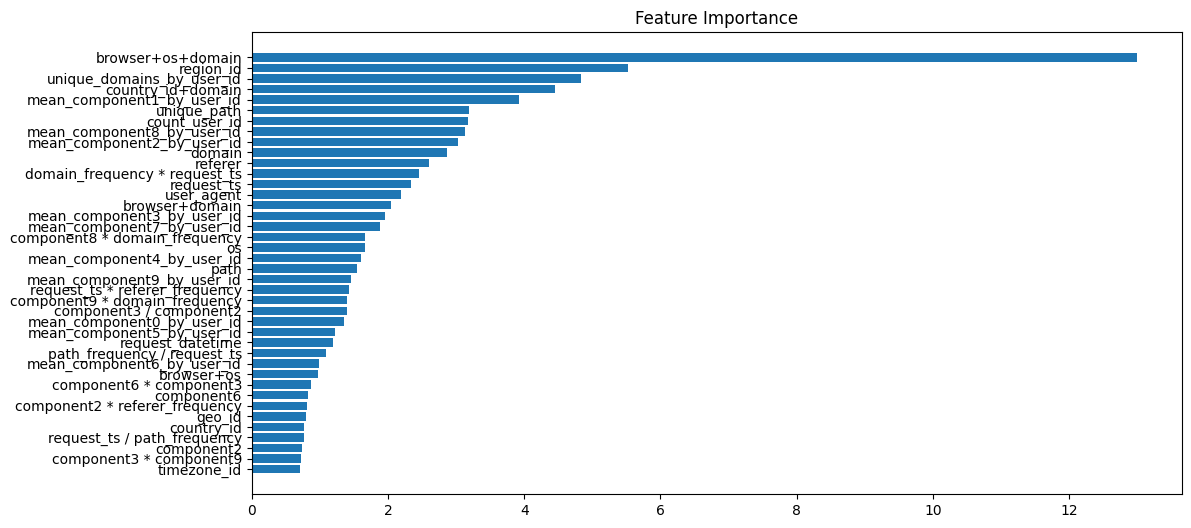

In [20]:
import numpy as np
import matplotlib.pyplot as plt

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)[-40:]
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.title("Feature Importance")

In [21]:
# import shap

# val_pool = Pool(X_val, y_val)
# shap_values = model.get_feature_importance(val_pool, type='ShapValues')[:, :-1]
# shap.summary_plot(shap_values, X_val)

Text(0.5, 1.0, 'Permutation Importance')

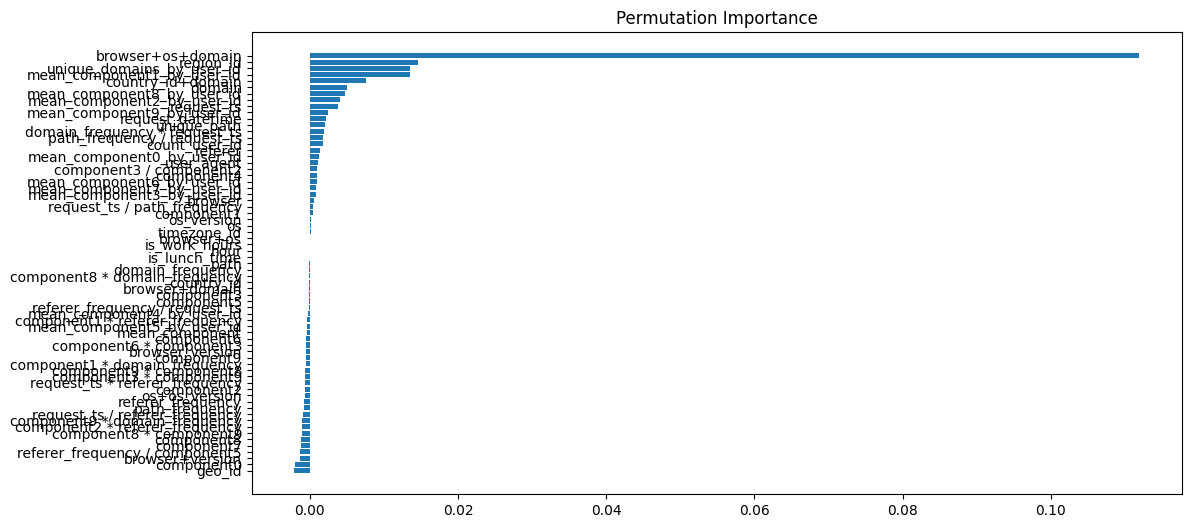

In [22]:
perm_importance = permutation_importance(
    model, X_val.iloc[:10_000], y_val.iloc[:10_000], n_repeats=10, random_state=1066
)
sorted_idx = perm_importance.importances_mean.argsort() #[-30:]
fig = plt.figure(figsize=(12, 6))
plt.barh(
    range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align="center"
)
plt.yticks(range(len(sorted_idx)), np.array(X_val.columns)[sorted_idx])
plt.title("Permutation Importance")

In [98]:
for idx in sorted_idx[::-1]:
    print(f"{X_train.columns[idx]}: {perm_importance.importances_mean[idx]:.4f}")

browser+os+domain: 0.1378
mean_component1_by_user_id: 0.0142
region_id: 0.0107
unique_domains_by_user_id: 0.0085
referer: 0.0082
country_id+domain: 0.0058
request_ts / path_frequency: 0.0046
domain: 0.0041
browser+os+country: 0.0038
request_ts: 0.0033
user_agent: 0.0030
path_frequency / request_ts: 0.0028
mean_component2_by_user_id: 0.0027
mean_component9_by_user_id: 0.0021
std_component4_by_user_id: 0.0020
mean_component0_by_user_id: 0.0020
browser+domain: 0.0020
component3 / component2: 0.0017
mean_component8_by_user_id: 0.0017
std_component0_by_user_id: 0.0016
std_component9_by_user_id: 0.0015
std_component7_by_user_id: 0.0014
request_datetime: 0.0014
path: 0.0013
request_ts * referer_frequency: 0.0012
mean_component4_by_user_id: 0.0011
component8 * domain_frequency: 0.0011
range_component2_by_user_id: 0.0011
component9 * domain_frequency: 0.0010
mean_component3_by_user_id: 0.0010
component3: 0.0010
browser+os: 0.0010
requests_per_hour_by_region: 0.0010
std_component1_by_user_id: 0.

In [99]:
remaining_columns = X_train.columns[sorted_idx[20:]]

In [100]:
X_train = X_train[remaining_columns]
X_val = X_val[remaining_columns]
X_test = X_test[remaining_columns]

Converting dataset to int/float values

In [19]:
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

text_cols = [
    col for col in X_train.columns[X_train.dtypes == object] if col != "user_id"
]

for col in tqdm(text_cols):
    enc = LabelEncoder()
    enc.fit(list(X_train[col]) + list(X_val[col]) + list(X_test[col]))

    X_train[col] = enc.transform(X_train[col])
    X_val[col] = enc.transform(X_val[col])
    X_test[col] = enc.transform(X_test[col])

100%|██████████| 17/17 [00:25<00:00,  1.51s/it]


In [20]:
X_train["request_datetime"] = X_train["request_datetime"].values.astype(float)
X_val["request_datetime"] = X_val["request_datetime"].values.astype(float)
X_test["request_datetime"] = X_test["request_datetime"].values.astype(float)

In [21]:
X_train = X_train.fillna(0)
X_val = X_val.fillna(0)
X_test = X_test.fillna(0)

In [22]:
X_public = pd.concat([X_train, X_val])

## LightAutoML

In [24]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

roles = {"target": "target", "drop": []}

automl = TabularAutoML(
    task=Task(
        "binary",
        metric=roc_auc_score,
    ),
    timeout=20000,
    gpu_ids="0",
    debug=True,
    general_params={
        "use_algos": [
            [
                "cb_tuned",
                "lgb",
                "lgb_tuned",
                "xgb",
                "xgb_tuned",
                "mlp_tuned",
                "autoint_tuned",
                "fttransformer_tuned",
            ],
            [
                "lgb_tuned",
                "linear_l2",
            ],
        ],
        "skip_conn": True,
    },
    nn_pipeline_params={
        "use_te": True,
    },
    reader_params={
        "n_jobs": 4,
        "cv": 5,
        "random_state": 41,
    },
)

In [25]:
new_X = X_public.copy()
new_X['target'] = list(y_train) + list(y_val)

In [ ]:
oof_pred = automl.fit_predict(
    new_X,
    roles=roles,
    verbose=1,
)

In [27]:
y_pred = automl.predict(X_test).data[:, 0]
y_pred

In [29]:
submission = X_test.copy()
submission["target"] = y_pred
submission[["user_id", "target"]].to_csv("lgbms_submission.csv", index=False, sep=';')